Author : Rohit Kumar Hansdah
Last Updated : 23 December

In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.utils import shuffle
import lightgbm as lgb
from lightgbm import LGBMClassifier
import eli5

from catboost import CatBoostClassifier
import xgboost as xgb




import riiideducation

%matplotlib inline
# for heatmap and other plots
colorMap1 = sns.color_palette("RdBu_r")
# for countplot and others plots
colorMap2 = 'Blues_r'



In [3]:
sampler = TPESampler(
    seed=666
)

In [4]:
types = {
        'row_id': 'int64', 
        'timestamp': 'int64', 
        'user_id': 'int32', 
        'content_id': 'int16', 
        'content_type_id': 'int8',
        'task_container_id': 'int16', 
        'user_answer': 'int8', 
        'answered_correctly': 'int8', 
        'prior_question_elapsed_time': 'float32', 
        'prior_question_had_explanation': 'boolean'
}

In [5]:
train = pd.read_csv(
    '/kaggle/input/riiid-test-answer-prediction/train.csv', 
    low_memory=False, 
    nrows=10**6, 
    dtype=types
)
questions=pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures=pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
test=pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')

train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


#                  DATA EXPLORATION & EDA

**TRAIN**

**row_id**: (int64) ID code for the row.

**timestamp**: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

**user_id**: (int32) ID code for the user.

**content_id**: (int16) ID code for the user interaction

**content_type_id**: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

**task_container_id**: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

**user_answer**: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

**answered_correctly**: (int8) if the user responded correctly. Read -1 as null, for lectures.

**prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures
in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

**prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [6]:
print(f"Train shape: {train.shape}")

Train shape: (1000000, 10)


In [7]:

train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [8]:
train.describe().style.background_gradient(cmap='Blues')

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000
mean,499999.500000,7344311266.729203,10172549.789739,5232.691523,0.019907,806.105689,1.374784,0.617504,25319.472656
std,288675.278933,10586930270.349688,6029233.863875,3882.323419,0.139681,1025.887530,1.194168,0.525364,19707.429688
min,0.000000,0.000000,115.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000
25%,249999.750000,521166935.500000,4702585.000000,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000
50%,499999.500000,2824811074.000000,9678259.000000,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000
75%,749999.250000,10101863021.250000,15568723.000000,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000
max,999999.000000,78091996556.000000,20949024.000000,32736.000000,1.000000,7739.000000,3.000000,1.000000,300000.000000


In [9]:
print(f'Number of unique users: {len(np.unique(train.user_id))}')


Number of unique users: 3824


Lets look at the missing data

In [10]:
print(train.isnull().sum()/len(train))

row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
prior_question_elapsed_time       0.023723
prior_question_had_explanation    0.003816
dtype: float64


Also let's check a correlation matrix to get more information between the columns

In [11]:
corr_matrix=train.corr()
corr_matrix['answered_correctly'].sort_values(ascending=True)

content_type_id                  -0.438788
content_id                       -0.203327
row_id                           -0.015589
user_id                          -0.014776
prior_question_elapsed_time       0.003251
timestamp                         0.027571
task_container_id                 0.039130
user_answer                       0.126721
prior_question_had_explanation    0.267835
answered_correctly                1.000000
Name: answered_correctly, dtype: float64

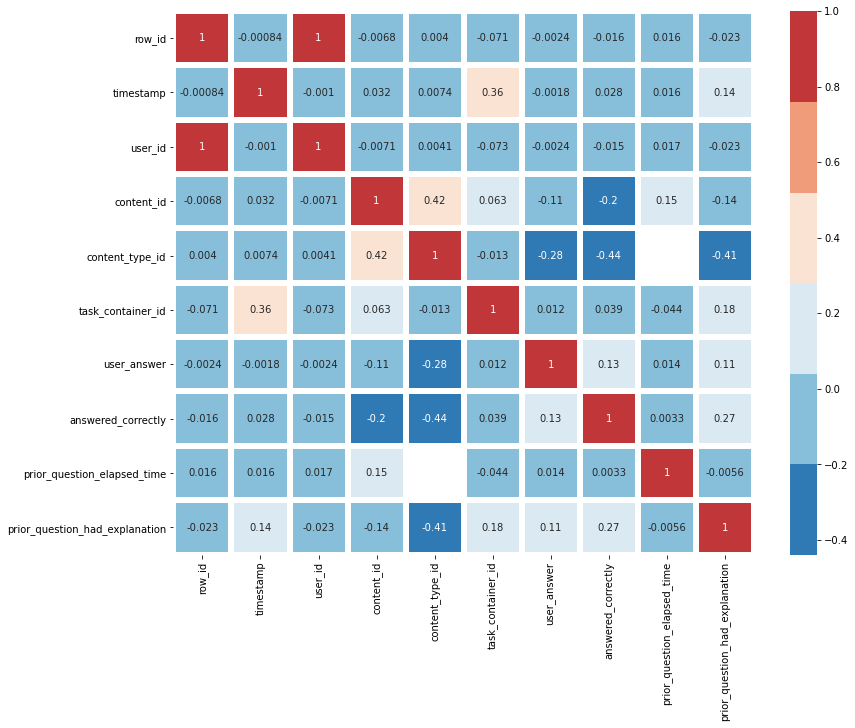

In [12]:
plt.figure(figsize=(13,10))
sns.heatmap(corr_matrix,annot=True,
           linewidths=5,cmap=colorMap1)







Let's check the distribution of **prior_question_elapsed_time** 

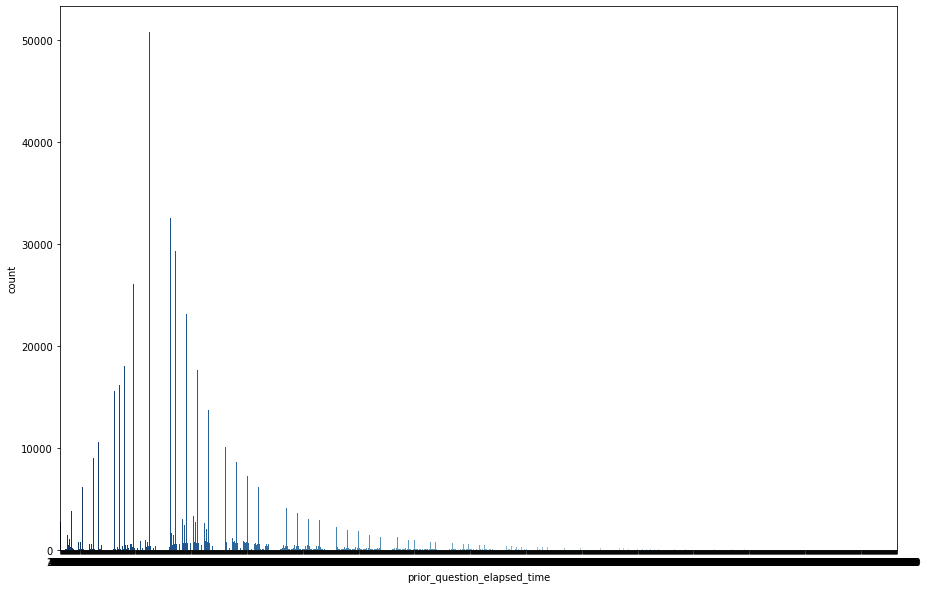

In [13]:
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="prior_question_elapsed_time", 
                   data=train[train['prior_question_elapsed_time'].notnull()],
                   palette=colorMap2)


Let's check any connection between our target value and a frequency of answering questions

In [14]:
freq_answered_tasks = train['task_container_id'].value_counts().reset_index()
freq_answered_tasks.columns = [
    'task_container_id', 
    'freq'
]
train['freq_task_id'] = ''
train.loc[train['task_container_id'].isin(freq_answered_tasks[freq_answered_tasks['freq'] < 10000]['task_container_id'].values), 'freq_task_id'] = 'very rare answered'
train.loc[train['task_container_id'].isin(freq_answered_tasks[freq_answered_tasks['freq'] >= 10000]['task_container_id'].values), 'freq_task_id'] = 'rare answered'
train.loc[train['task_container_id'].isin(freq_answered_tasks[freq_answered_tasks['freq'] >= 50000]['task_container_id'].values), 'freq_task_id'] = 'normal answered'
train.loc[train['task_container_id'].isin(freq_answered_tasks[freq_answered_tasks['freq'] >= 200000]['task_container_id'].values), 'freq_task_id'] = 'often answered'
train.loc[train['task_container_id'].isin(freq_answered_tasks[freq_answered_tasks['freq'] >= 400000]['task_container_id'].values), 'freq_task_id'] = 'very often answered'



In [15]:
train.sample(5)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,freq_task_id
793998,793998,9262473729,16159973,5637,0,700,0,1,20000.0,True,very rare answered
997337,997337,1179553,20873022,438,0,24,3,1,15000.0,True,very rare answered
661766,661766,34159464706,13447062,9981,0,1472,2,0,36000.0,True,very rare answered
649179,649179,11518460056,13149581,32023,1,1752,-1,-1,NaN,False,very rare answered
591394,591394,512209808,11899332,345,0,116,1,1,11000.0,True,very rare answered


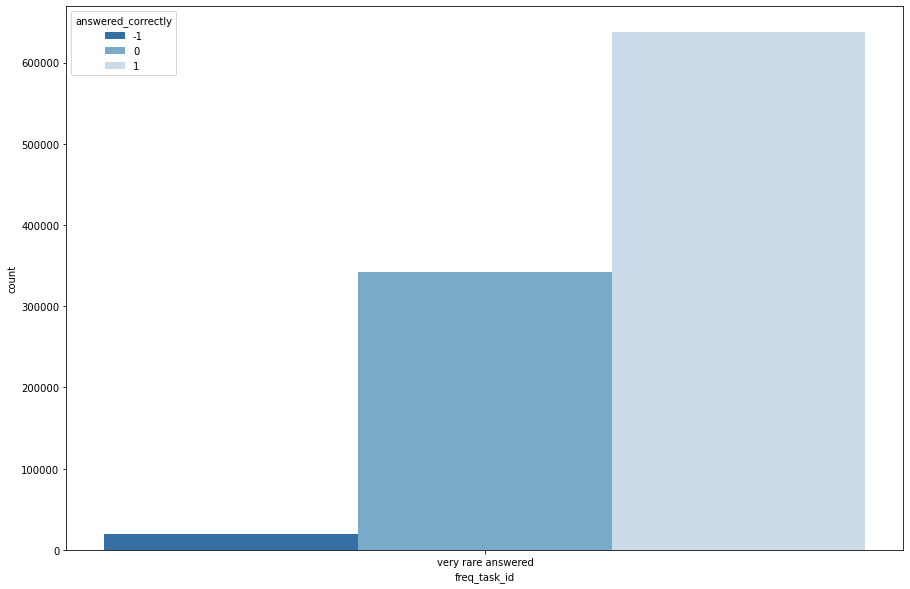

In [16]:
plt.figure(figsize=(15, 10))
sns.countplot(x='freq_task_id', hue='answered_correctly', data=train, palette=colorMap2)

In [17]:
WIDTH=800

In [18]:
ds = train['answered_correctly'].value_counts().reset_index()

ds.columns = [
    'answered_correctly', 
    'percent_of_answers'
]

ds['percent_of_answers'] /= len(train)
ds = ds.sort_values(['percent_of_answers'])

fig = px.pie(
    ds, 
    names='answered_correctly', 
    values='percent_of_answers', 
    title='Percent of correct answers', 
    width=WIDTH,
    height=500 
)


fig.show()

prior_question_had_explanation has a medium correlation with the target value. So let's look at his distribution



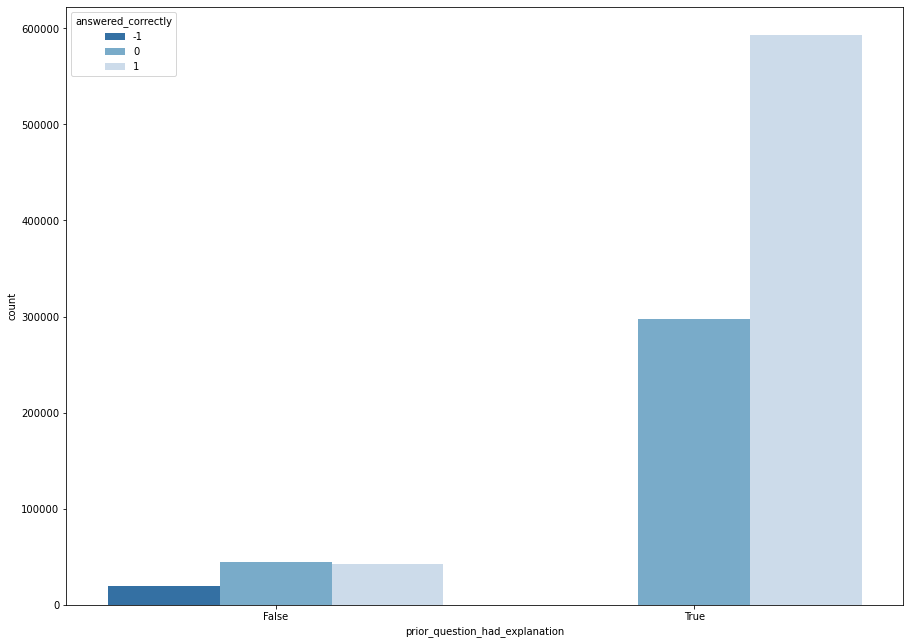

In [19]:
plt.figure(figsize=(15, 11))
ax = sns.countplot(x="prior_question_had_explanation", hue="answered_correctly", data=train[train['prior_question_had_explanation'].notnull()], palette=colorMap2)

The answer's showing increases the probability of a successful answering. Let's go further.
Check the most active user_id



Text(0.5, 1.0, 'Top 30 the most active users')

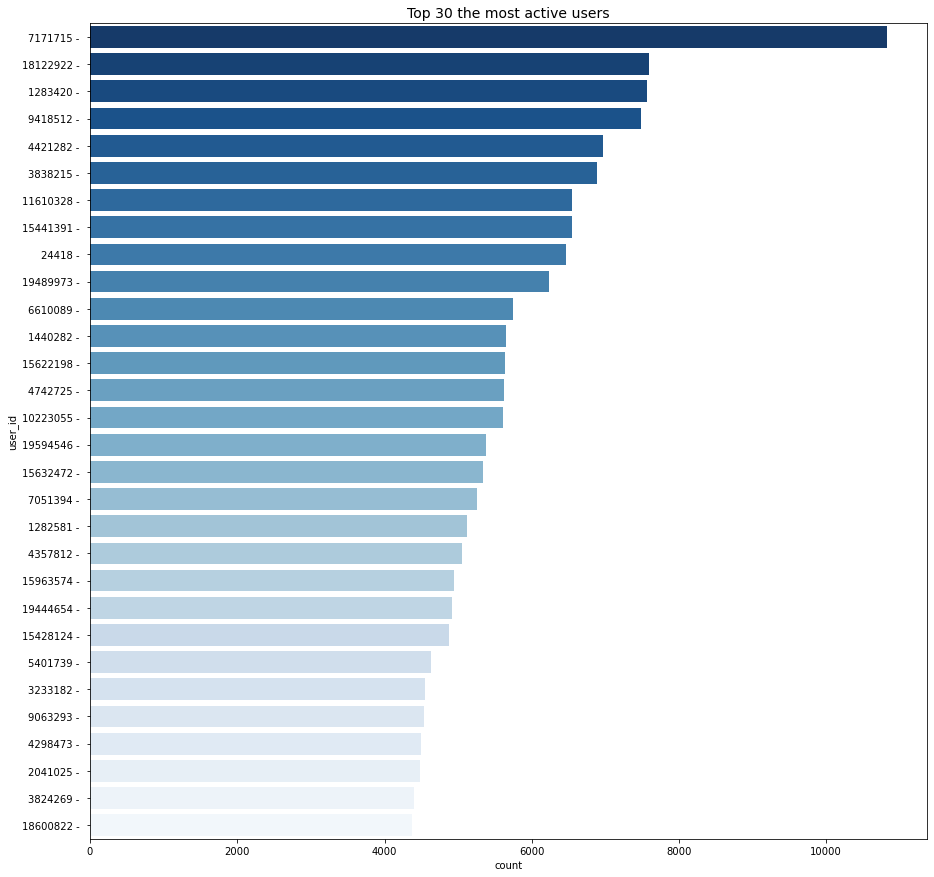

In [20]:
N=30

user_freq = train['user_id'].value_counts().reset_index()
user_freq.columns = [
    'user_id', 
    'count'
]

# Add ' - ' to convert user_id to str and not sort
user_freq['user_id'] = user_freq['user_id'].astype(str) + ' - '
user_freq = user_freq.sort_values(['count'], ascending=False).head(N)

plt.figure(figsize=(15, 15))
sns.barplot(x='count', y='user_id', data=user_freq, orient='h', palette=colorMap2)
plt.title(f'Top {N} the most active users', fontsize=14)

And the most useful content_id

In [21]:
WIDTH=800

Also we need to check distribution in content_type_id: number of video lectures and questions

In [22]:
ds = train['content_type_id'].value_counts().reset_index()

ds.columns = [
    'content_type_id', 
    'percent'
]

ds['percent'] /=len(train)

fig = px.pie(
    ds, 
    names='content_type_id', 
    values='percent', 
    title='Lecures & questions', 
    width=WIDTH,
    height=500 
)

fig.show()

In [23]:
ds=train['user_answer'].value_counts().reset_index()
ds.columns = [
    'user_answer', 
    'percent_of_answers'
]
ds['percent_of_answers']/=len(train)
ds = ds.sort_values(['percent_of_answers'])
fig = px.bar(
    ds, 
    x='user_answer', 
    y='percent_of_answers', 
    orientation='v', 
    title='Percent of user answers for every option', 
    width=WIDTH,
    height=400 
)

fig.show()

([<matplotlib.axis.XTick at 0x7f9137137a10>,
 [Text(0, 0, '0'),
  Text(0, 0, '1000'),
  Text(0, 0, '2000'),
  Text(0, 0, '3000'),
  Text(0, 0, '4000'),
  Text(0, 0, '5000'),
  Text(0, 0, '6000'),
  Text(0, 0, '7000')])

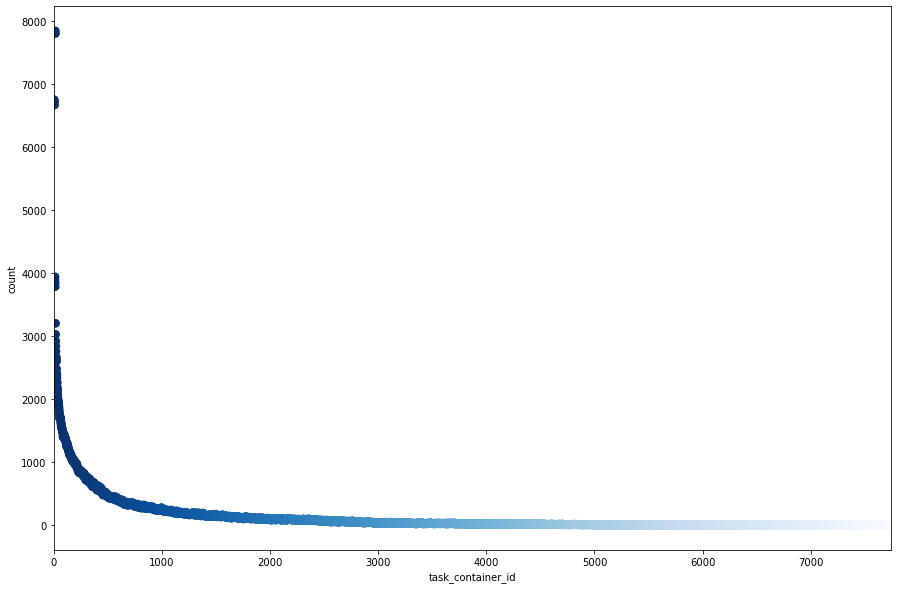

In [24]:
task_ids_freq = train['task_container_id'].value_counts().reset_index()
task_ids_freq.columns = ['task_container_id', 'count']

fig, ax = plt.subplots(figsize=(15, 10))

sns.pointplot(x='task_container_id', y='count', data=task_ids_freq, palette=colorMap2)
xticks_range = range(min(task_ids_freq['task_container_id']), 
                     max(task_ids_freq['task_container_id']),
                     1000)
plt.xticks(list(xticks_range), list(xticks_range))

**QUESTIONS.CSV**


question_id: foreign key for the train/test content_id column, when the content type is question (0).

bundle_id: code for which questions are served together.

correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

part: top level category code for the question.

tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [25]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [26]:
questions.describe().style.background_gradient(cmap='Blues')

,question_id,bundle_id,correct_answer,part
count,13523.000000,13523.000000,13523.000000,13523.000000
mean,6761.000000,6760.510907,1.455298,4.264956
std,3903.898180,3903.857783,1.149707,1.652553
min,0.000000,0.000000,0.000000,1.000000
25%,3380.500000,3379.500000,0.000000,3.000000
50%,6761.000000,6761.000000,1.000000,5.000000
75%,10141.500000,10140.000000,3.000000,5.000000
max,13522.000000,13522.000000,3.000000,7.000000


In [27]:
print(questions.isnull().sum() / len(questions))

question_id       0.000000
bundle_id         0.000000
correct_answer    0.000000
part              0.000000
tags              0.000074
dtype: float64


In [28]:





questions['tag'] = questions['tags'].str.split(' ')
questions = questions.explode('tag')
questions = pd.merge(
    questions, 
    questions.groupby('question_id')['tag'].count().reset_index(), 
    on='question_id'
    )

questions = questions.drop(['tag_x'], axis=1)

questions.columns = [
    'question_id', 
    'bundle_id', 
    'correct_answer', 
    'part', 
    'tags', 
    'tags_number'
]
questions = questions.drop_duplicates()

In [29]:
ds = questions['correct_answer'].value_counts().reset_index()

ds.columns = [
    'correct_answer', 
    'number_of_answers'
]

ds['correct_answer'] = ds['correct_answer'].astype(str) + '-'
ds = ds.sort_values(['number_of_answers'])

fig = px.bar(
    ds, 
    x='number_of_answers', 
    y='correct_answer', 
    orientation='h', 
    title='Number of correct answers per group', 
    width=WIDTH,
    height=300
)
fig.show()

In [30]:
ds = questions['part'].value_counts().reset_index()

ds.columns = [
    'part', 
    'count'
]

ds['part'] = ds['part'].astype(str) + '-'
ds = ds.sort_values(['count'])

fig = px.bar(
    ds, 
    x='count', 
    y='part', 
    orientation='h', 
    title='Parts distribution',
    width=WIDTH,
    height=400
)
fig.show()

In [31]:
ds = questions['tags_number'].value_counts().reset_index()

ds.columns = [
    'tags_number', 
    'count'
]

ds['tags_number'] = ds['tags_number'].astype(str) + '-'
ds = ds.sort_values(['tags_number'])

fig = px.bar(
    ds, 
    x='count', 
    y='tags_number', 
    orientation='h', 
    title='Number tags distribution', 
    width=WIDTH,
    height=400 
    )

fig.show()

In [32]:


check = questions['tags'].str.split(' ').explode('tags').reset_index()
check = check['tags'].value_counts().reset_index()

check.columns = [
    'tag', 
    'count'
]

check['tag'] = check['tag'].astype(str) + '-'
check = check.sort_values(['count']).tail(40)

fig = px.bar(
    check, 
    x='count', 
    y='tag', 
    orientation='h', 
     title='Top 40 most useful tags', 
    width=WIDTH,
    height=900 
)

fig.show()


LECTURES.CSV

Metadata for the lectures watched by users as they progress in their education.

**lecture_id**: foreign key for the train/test content_id column, when the content type is lecture (1).

**part**: top level category code for the lecture.

**tag**: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

**type_of**: brief description of the core purpose of the lecture

In [33]:
lectures.head(10)

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question
5,335,114,2,concept
6,484,179,5,concept
7,641,134,6,solving question
8,761,93,1,concept
9,814,80,5,solving question


In [34]:
print('Part of missing values for every column')
print(lectures.isnull().sum() / len(lectures))

Part of missing values for every column
lecture_id    0.0
tag           0.0
part          0.0
type_of       0.0
dtype: float64


In [35]:
lectures['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

**Test.csv**

In [36]:
test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


# FEATURE ENGINEERING

In [37]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,freq_task_id
0,0,0,115,5692,0,1,3,1,NaN,<NA>,very rare answered
1,1,56943,115,5716,0,2,2,1,37000.0,False,very rare answered
2,2,118363,115,128,0,0,0,1,55000.0,False,very rare answered
3,3,131167,115,7860,0,3,0,1,19000.0,False,very rare answered
4,4,137965,115,7922,0,4,1,1,11000.0,False,very rare answered


In [38]:
features_df = train.iloc[:int(9/10 * len(train))]
train = train.iloc[int(9/10 * len(train)):]

In [39]:
train_questions_only_df = features_df[features_df['answered_correctly']!=-1]
grouped_by_user_df = train_questions_only_df.groupby('user_id')

user_answers_df = grouped_by_user_df.agg(
    {
        'answered_correctly': [
            'mean', 
            'count', 
            'std', 
            'median', 
            'skew'
        ]
    }
).copy()

user_answers_df.columns = [
    'mean_user_accuracy',
    'questions_answered',
    'std_user_accuracy', 
    'median_user_accuracy', 
    'skew_user_accuracy'
]

In [40]:
grouped_by_content_df = train_questions_only_df.groupby('content_id')
content_answers_df = grouped_by_content_df.agg(
    {
        'answered_correctly': [
            'mean', 
            'count', 
            'std', 
            'median', 
            'skew'
        ]
    }
).copy()

content_answers_df.columns = [
    'mean_accuracy', 
    'question_asked', 
    'std_accuracy', 
    'median_accuracy', 
    'skew_accuracy'
]
content_answers_df

,mean_accuracy,question_asked,std_accuracy,median_accuracy,skew_accuracy
content_id,,,,,
0,0.857143,70,0.352454,1.0,-2.086215
1,0.918367,49,0.276642,1.0,-3.153323
2,0.555276,398,0.497561,1.0,-0.223312
3,0.784091,176,0.412625,1.0,-1.392819
4,0.600760,263,0.490676,1.0,-0.413848
...,...,...,...,...,...
13518,0.714286,7,0.487950,1.0,-1.229634
13519,0.500000,8,0.534522,0.5,0.000000
13520,0.700000,10,0.483046,1.0,-1.035098


In [41]:
del features_df
del grouped_by_user_df
del grouped_by_content_df

In [42]:
features = [
    'mean_user_accuracy', 
    'questions_answered',
    'std_user_accuracy', 
    'median_user_accuracy',
    'skew_user_accuracy',
    'mean_accuracy', 
    'question_asked',
    'std_accuracy', 
    'median_accuracy',
    'prior_question_elapsed_time', 
    'prior_question_had_explanation',
    'skew_accuracy'
]

target = 'answered_correctly'

In [43]:
target

'answered_correctly'

In [44]:
train = train[train[target] != -1]

In [45]:
train = train.merge(user_answers_df, how='left', on='user_id')
train = train.merge(content_answers_df, how='left', on='content_id')

In [46]:
target

'answered_correctly'

In [47]:

train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(value=False).astype(bool)
df = train.fillna(value=0.5)

In [48]:
col_to_drop = set(train.columns.values.tolist()).difference(features + [target])
for col in col_to_drop:
    del df[col]

In [49]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0.5)

# Modeling

In [50]:
train_df, test_df, y_train, y_test = train_test_split(df[features], df[target], random_state=777, test_size=0.2)

# LGBM classifier

In [51]:
params = {
    'num_leaves': 30, 
    'n_estimators': 300, 
    'min_data_in_leaf': 100, 
    'max_depth': 5, 
    'lambda': 0.0, 
    'feature_fraction': 1.0
}


In [52]:
model = LGBMClassifier(**params)
model.fit(train_df, y_train)

LGBMClassifier(feature_fraction=1.0, lambda=0.0, max_depth=5,
               min_data_in_leaf=100, n_estimators=300, num_leaves=30)

In [53]:
print('LGB ROC-AUC score: ', roc_auc_score(y_test.values, model.predict_proba(test_df)[:, 1]))

LGB ROC-AUC score:  0.7124265003484616


# Random forest classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier()
rfclf.fit(train_df,y_train)
pred = rfclf.predict(test_df)

In [55]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test,pred))

0.5863760967808772


# Xgboost classifier

In [56]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier()
xgbclf.fit(train_df,y_train)
xgb_pred = xgbclf.predict(test_df)

In [57]:
print(roc_auc_score(y_test,xgb_pred))

0.610247473137224


In [58]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(train_df,y_train)
mlp_pred = mlp.predict(test_df)

In [59]:
print(roc_auc_score(y_test,mlp_pred))

0.6415505836558


In [60]:
eli5.show_weights(model, top=20)

Weight,Feature
0.7253,mean_accuracy
0.0895,std_accuracy
0.0803,prior_question_elapsed_time
0.0600,question_asked
0.0389,skew_accuracy
0.0060,prior_question_had_explanation
0,median_accuracy
0,skew_user_accuracy
0,median_user_accuracy
0,std_user_accuracy


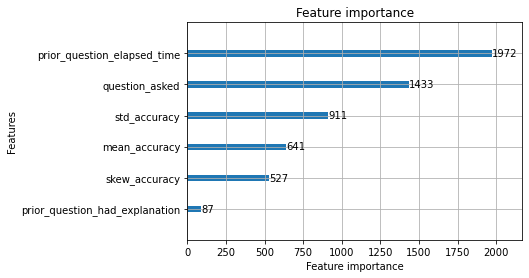

In [61]:
lgb.plot_importance(model)

Submission preparation

In [62]:
env = riiideducation.make_env()

In [63]:
iter_test = env.iter_test()

In [64]:
for (test_df, sample_prediction_df) in iter_test:
    # merge
    test_df = test_df.merge(user_answers_df, on = "user_id", how = "left")
    #test_df = test_df.merge(task_container_characteristics, on = "task_container_id", how = "left")
    test_df = test_df.merge(content_answers_df, on = "content_id", how = "left")
    
    # type transformation
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value=False).astype(bool)
    test_df.fillna(value = 0.5, inplace = True)
    test_df = test_df.replace([np.inf, -np.inf], np.nan)
    test_df = test_df.fillna(0.5)
    
    # preds
    test_df['answered_correctly'] = model.predict_proba(test_df[features])[:, 1]
    cols_to_submission = ['row_id', 'answered_correctly', 'group_num']
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])